<a href="https://colab.research.google.com/github/afortuny/DeepLearningFastAI/blob/main/06_Image%20Regression%20for%20Crowd%20Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 719 kB 6.7 MB/s 
     |████████████████████████████████| 197 kB 50.2 MB/s 
     |████████████████████████████████| 346 kB 57.4 MB/s 
     |████████████████████████████████| 4.2 MB 7.9 MB/s 
     |████████████████████████████████| 1.2 MB 58.1 MB/s 
     |████████████████████████████████| 60 kB 8.0 MB/s 
     |████████████████████████████████| 1.1 MB 59.7 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 140 kB 63.5 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 212 kB 74.2 MB/s 
     |████████████████████████████████| 596 kB 64.7 MB/s 
     |████████████████████████████████| 127 kB 68.6 MB/s 
     |████████████████████████████████| 271 kB 73.4 MB/s 
     |████████████████████████████████| 144 kB 74.4 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 112 kB 76.6 MB/s 
     |██████████████████

In [3]:
#hide
from fastbook import *

## Regression

It's easy to think of deep learning models as being classified into domains, like *computer vision*, *NLP*, and so forth. And indeed, that's how fastai classifies its applications—largely because that's how most people are used to thinking of things.

But really, that's hiding a more interesting and deeper perspective. A model is defined by its independent and dependent variables, along with its loss function. That means that there's really a far wider array of models than just the simple domain-based split. Perhaps we have an independent variable that's an image, and a dependent that's text (e.g., generating a caption from an image); or perhaps we have an independent variable that's text and dependent that's an image (e.g., generating an image from a caption—which is actually possible for deep learning to do!); or perhaps we've got images, texts, and tabular data as independent variables, and we're trying to predict product purchases... the possibilities really are endless.

To be able to move beyond fixed applications, to crafting your own novel solutions to novel problems, it helps to really understand the data block API (and maybe also the mid-tier API, which we'll see later in the book). As an example, let's consider the problem of *image regression*. This refers to learning from a dataset where the independent variable is an image, and the dependent variable is one or more floats. Often we see people treat image regression as a whole separate application—but as you'll see here, we can treat it as just another CNN on top of the data block API.

We're going to jump straight to a very interesting problem to estimate the number of people in a space, which have very interesting usages to know the real time usage of public transport. The dataset we will use is on a store, but the application remains relevant if we leverage train data to count people.

Here is the data set location : https://personal.ie.cuhk.edu.hk/~ccloy/downloads_mall_dataset.html . the labels can be found here: https://www.kaggle.com/code/kerneler/starter-mall-crowd-estimation-07f95d24-3/data





### Assemble the Data

We will use the [Mall Crowd estimation data set](https://www.kaggle.com/code/kerneler/starter-mall-crowd-estimation-07f95d24-3/data) for this section. We have 2000 frames from a mall and the number of people on them. 

In [ ]:
# We will unzip the images file
#!unzip '/content/gdrive/MyDrive/Crowd/frames.zip' -d '/content/gdrive/MyDrive/Crowd'

In [4]:
# load the labels
df = pd.read_csv('/content/gdrive/MyDrive/Crowd/labels.csv')

In [5]:
df.head() 
# note that the image index and the file name does not correspond, 
# we need to change the index to map exactly the image name

,h5_index,img_seq,label
0,0,1,29
1,1,2,30
2,2,3,35
3,3,4,31
4,4,5,26


In [6]:
df['img_seq2'] = df.img_seq.apply(lambda x: 'seq_{:06d}.jpg'.format(x)) # reformat img_seq

In [7]:
df['img_seq'] = df['img_seq2'] #remove all img seq id

In [8]:
df = df[['img_seq', 'label']] # keep only essential columns

In [9]:
def get_y(df): return df['label'] # to get labels labels
import pathlib 
path = pathlib.Path('/content/gdrive/MyDrive/Crowd')
block = DataBlock(blocks=(ImageBlock, RegressionBlock), #note we change to RegressionBlock
                   get_x=ColReader(0, pref=path/"frames"), #similar approach as with multilabel
                   get_y=get_y,
                   splitter=RandomSplitter(valid_pct=0.2, seed=42),
                   item_tfms=Resize(224),
                   batch_tfms=aug_transforms())

In [10]:
dls = block.dataloaders(df)

In [11]:
len(dls.train_ds), len(dls.valid_ds)

(1600, 400)

Before doing any modeling, we should look at our data to confirm it seems okay:

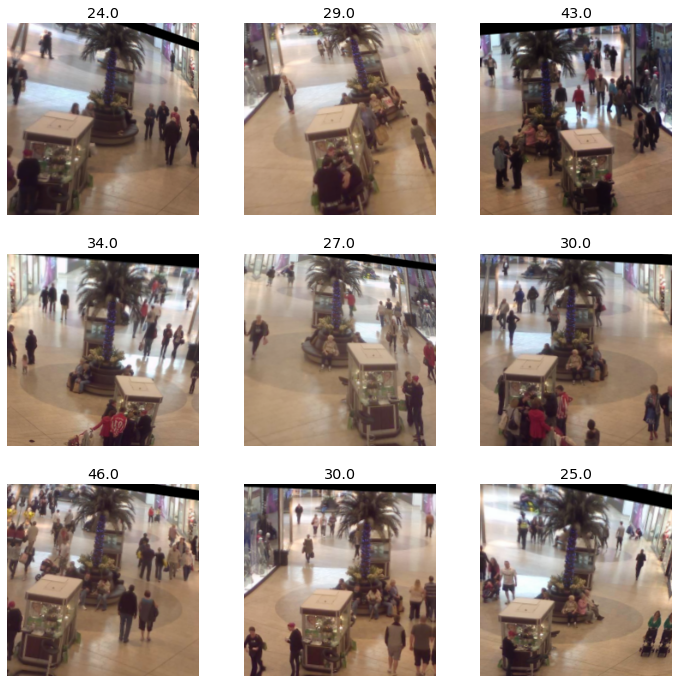

In [12]:
dls.show_batch(figsize=(12,12))

That's looking good! As well as looking at the batch visually, it's a good idea to also look at the underlying tensors (especially as a student; it will help clarify your understanding of what your model is really seeing):

In [13]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

Make sure that you understand *why* these are the shapes for our mini-batches.

Here's an example of one row from the dependent variable:

In [14]:
yb[0]

tensor(23., device='cuda:0')

As you can see, we haven't had to use a separate *image regression* application; all we've had to do is label the data, and tell fastai what kinds of data the independent and dependent variables represent.

It's the same for creating our `Learner`. We will use the same function as before, with one new parameter, and we will be ready to train our model.

### Training a Model

As usual, we can use `vision_learner` to create our `Learner`.We used `y_range` to tell fastai the range of our targets? We'll do the same here.

In [19]:
learn = vision_learner(dls, resnet18, y_range=(12,53),metrics=mae)

We didn't specify a loss function, which means we're getting whatever fastai chooses as the default. Let's see what it picked for us:

In [20]:
dls.loss_func

FlattenedLoss of MSELoss()

This makes sense, since most of the time we're likely to be trying to predict something as close as possible; that's basically what `MSELoss` (mean squared error loss) does. If you want to use a different loss function, you can pass it to `vision_learner` using the `loss_func` parameter.

Note also that we didn't specify any metrics. That's because the MSE is already a useful metric for this task (although it's probably more interpretable after we take the square root). 

We can pick a good learning rate with the learning rate finder:

SuggestedLRs(valley=0.0003311311302240938)

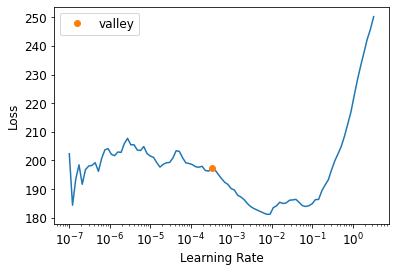

In [17]:
learn.lr_find()

We'll try an LR of 3e-4:

In [28]:
lr = 0.00033
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,mae,time
0,12.264143,12.128557,2.524325,00:16


epoch,train_loss,valid_loss,mae,time
0,13.450002,10.253848,2.378665,00:17
1,12.810927,10.848037,2.405813,00:18
2,12.859636,10.538904,2.389620,00:19


This sounds very accurate! But it's important to take a look at our results with `Learner.show_results`. The left side are the actual (*ground truth*) coordinates and the right side are our model's predictions:

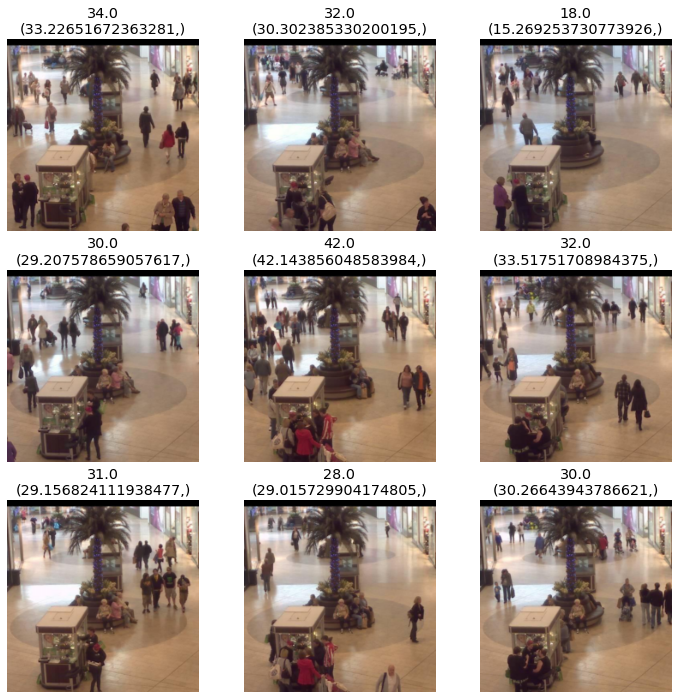

In [27]:
learn.show_results(figsize=(12,12))

It's quite amazing that with just a few minutes of computation we've created such an accurate crowd counting model, and without any special domain-specific application. This is the power of building on flexible APIs, and using transfer learning! It's particularly striking that we've been able to use transfer learning so effectively even between totally different tasks; our pretrained model was trained to do image classification, and we fine-tuned for image regression.

## Conclusion

In problems that are at first glance completely different (single-label classification, multi-label classification, and regression), we end up using the same model with just different numbers of outputs. The loss function is the one thing that changes, which is why it's important to double-check that you are using the right loss function for your problem.

fastai will automatically try to pick the right one from the data you built, but if you are using pure PyTorch to build your `DataLoader`s, make sure you think hard when you have to decide on your choice of loss function, and remember that you most probably want:

- `nn.CrossEntropyLoss` for single-label classification
- `nn.BCEWithLogitsLoss` for multi-label classification
- `nn.MSELoss` for regression